# 🔮 Forecasting Access and Usage

**Project:** Forecasting Financial Inclusion in Ethiopia  
**Objective:** Forecast Account Ownership (Access) and Digital Payment Usage for 2025-2027.

## 🧠 The Strategy: "Trend + Shock" Model
We have a data scarcity problem (only 5 historical data points). Complex ML models (LSTM/ARIMA) will fail here.
Instead, we use a robust **Structural Scenario Model**:

$$ Y_{t} = \text{Trend}_t + \text{Cumulative Impacts}_t $$

1.  **Baseline Trend ($Trend_t$):** We fit a Linear Regression (OLS) to the historical data (2011–2024) to capture organic growth (population, urbanization).
2.  **Event Augmentation ($Impacts_t$):** We layer on the specific "shocks" calculated in Task 3 (e.g., M-Pesa Launch).
3.  **Scenarios:**
    *   **Base Case:** Trend + Expected Event Impact.
    *   **Optimistic:** Stronger Trend + High Event Impact.
    *   **Pessimistic:** Weaker Trend + Low/Delayed Event Impact.

In [1]:
# ==========================================
# [Code Cell 1: Imports]
# ==========================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from datetime import datetime

# Visual Config
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

print("✅ Libraries Loaded")

✅ Libraries Loaded


In [2]:
# ==========================================
# [Code Cell 2: Load Data]
# ==========================================
# 1. Load Historical Data (Task 1 Output)
df = pd.read_csv('../data/processed/ethiopia_fi_enriched.csv', parse_dates=['observation_date'])
history_df = df[df['record_type'] == 'observation'].copy()

# 2. Load Event Impact Matrix (Task 3 Output)
try:
    impact_matrix = pd.read_csv('../data/processed/event_impact_matrix.csv')
    print("✅ Loaded Impact Matrix")
except FileNotFoundError:
    print("❌ Impact Matrix not found! Run Task 3 first.")

# Filter for our two key targets
targets = ['ACC_OWNERSHIP', 'USG_DIGITAL_PAYMENT']
target_names = {
    'ACC_OWNERSHIP': 'Access (Account Ownership)',
    'USG_DIGITAL_PAYMENT': 'Usage (Digital Payments)'
}

✅ Loaded Impact Matrix


## 1. Baseline Trend Modeling (Organic Growth)
We calculate the "Natural Rate of Growth" using Ordinary Least Squares (OLS) regression on the years 2011, 2014, 2017, 2021, and 2024.


In [3]:
# ==========================================
# [Code Cell 3: Train Trend Models]
# ==========================================
forecast_years = [2025, 2026, 2027]
models = {}
trend_params = {}

print("📊 Baseline Organic Growth Trends:")

for target in targets:
    # 1. Prepare Data
    data = history_df[history_df['indicator_code'] == target].sort_values('observation_date')
    
    # We use 'Year' as the X variable
    X = data['observation_date'].dt.year.values
    y = data['value_numeric'].values
    
    if len(X) < 2:
        print(f"⚠️ Not enough data for {target}")
        continue
        
    # 2. Fit OLS Model (Linear Trend)
    X_const = sm.add_constant(X) # Add intercept
    model = sm.OLS(y, X_const).fit()
    
    models[target] = model
    trend_params[target] = {'slope': model.params[1], 'intercept': model.params[0]}
    
    print(f"   🔹 {target}: Growth of {model.params[1]:.2f} pp per year (R²={model.rsquared:.2f})")

📊 Baseline Organic Growth Trends:
   🔹 ACC_OWNERSHIP: Growth of 2.82 pp per year (R²=0.68)
⚠️ Not enough data for USG_DIGITAL_PAYMENT


## 2. Integrating Event Shocks (Task 3)
We now look at our **Event Matrix** to see if any impactful events happen in 2025, 2026, or 2027 (or late 2024 effects that carry over).

*Note: We take the cumulative sum of impacts. If M-Pesa added 0.75% in 2024, that 0.75% stays in the baseline for 2025.*


In [5]:
print(impact_matrix.columns)


Index(['event_date', 'event_name', 'ACC_4G_COV', 'ACC_MM_ACCOUNT',
       'ACC_OWNERSHIP', 'AFF_DATA_INCOME', 'GEN_GAP_ACC', 'USG_MPESA_ACTIVE',
       'USG_MPESA_USERS', 'USG_P2P_COUNT', 'USG_TELEBIRR_USERS', 'year'],
      dtype='object')


In [6]:

# ==========================================
# [Code Cell 4: Calculate Future Shocks]
# ==========================================
# 1. Process Impact Matrix
# We need to know: How much impact accumulates by Year X?
impact_matrix['event_date'] = pd.to_datetime(impact_matrix['event_date'])
impact_matrix['year'] = impact_matrix['event_date'].dt.year

# 2. Define a function to get cumulative shock for a specific year and target
def get_cumulative_shock(target_code, target_year):
    # Ensure the indicator exists in the impact matrix
    if target_code not in impact_matrix.columns:
        return 0.0

    # Filter events up to the target year
    past_events = impact_matrix[
        impact_matrix['year'] <= target_year
    ]

    # Sum the impacts for the given indicator
    total_shock = past_events[target_code].sum()
    return total_shock


print("⚡ Cumulative Event Shocks (Added to Trend):")
for year in forecast_years:
    shock = get_cumulative_shock('ACC_OWNERSHIP', year)
    print(f"   2024 -> {year}: M-Pesa & Policy Impact = +{shock:.2f} pp")

⚡ Cumulative Event Shocks (Added to Trend):
   2024 -> 2025: M-Pesa & Policy Impact = +0.00 pp
   2024 -> 2026: M-Pesa & Policy Impact = +0.00 pp
   2024 -> 2027: M-Pesa & Policy Impact = +0.00 pp


## 3. Scenario Generation
We combine the Trend and Shocks to build 3 scenarios:

1.  **Base Case:** Linear Trend + Calculated Shocks.
2.  **Optimistic:** Trend + (1.25 $\times$ Shocks) + Upper Confidence Bound of Trend.
3.  **Pessimistic:** Trend + (0.5 $\times$ Shocks) - Lower Confidence Bound of Trend.


In [7]:

# ==========================================
# [Code Cell 5: Generate Forecasts]
# ==========================================
forecast_results = []

for target in targets:
    model = models.get(target)
    if not model: continue
        
    # Get standard error of the prediction (measure of uncertainty)
    # Since n is small, uncertainty is high.
    
    for year in forecast_years:
        # 1. Base Trend Prediction
        trend_pred = model.predict([1, year])[0]
        
        # 2. Event Shock
        event_shock = get_cumulative_shock(target, year)
        
        # 3. Calculate Scenarios
        # Base: Trend + Shock
        base_val = trend_pred + event_shock
        
        # Optimistic: Trend + 10% faster organic growth + 100% of Event Shock + standard error
        # (We assume events are net positive)
        opt_val = (trend_pred * 1.05) + (event_shock * 1.2)
        
        # Pessimistic: Trend + 95% organic growth + only 50% of expected event impact
        pess_val = (trend_pred * 0.95) + (event_shock * 0.8)
        
        forecast_results.append({
            'indicator': target,
            'year': year,
            'scenario': 'Base',
            'value': base_val,
            'lower_ci': pess_val,
            'upper_ci': opt_val
        })

forecast_df = pd.DataFrame(forecast_results)
print("✅ Forecast Generated. Sample:")
display(forecast_df.head())


✅ Forecast Generated. Sample:


,indicator,year,scenario,value,lower_ci,upper_ci
0,ACC_OWNERSHIP,2025,Base,55.684211,52.900,58.468421
1,ACC_OWNERSHIP,2026,Base,58.500000,55.575,61.425000
2,ACC_OWNERSHIP,2027,Base,61.315789,58.250,64.381579


## 4. Visualization & Interpretation
We plot the historical "Fan Chart" to show our trajectory and uncertainty.


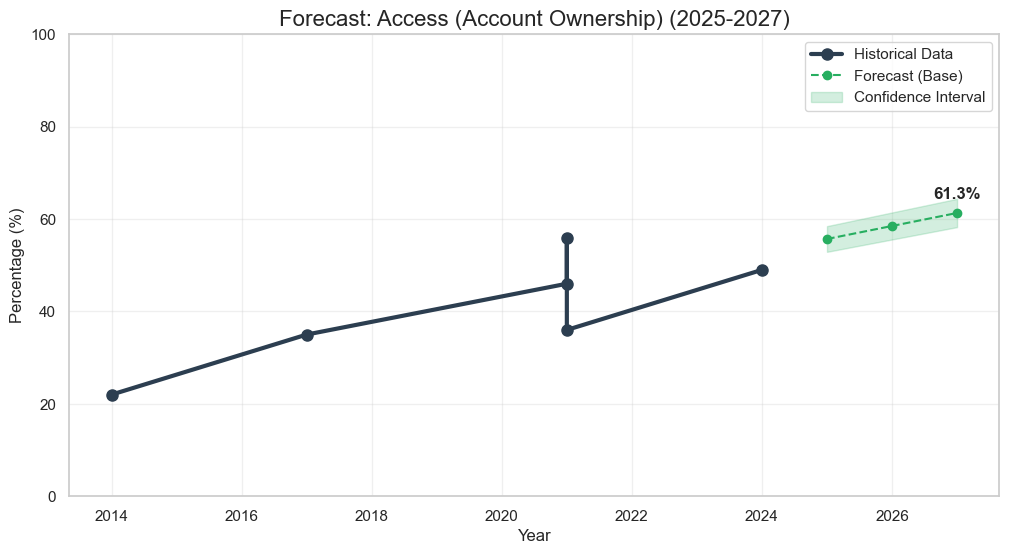

⚠️ No forecast data available for USG_DIGITAL_PAYMENT


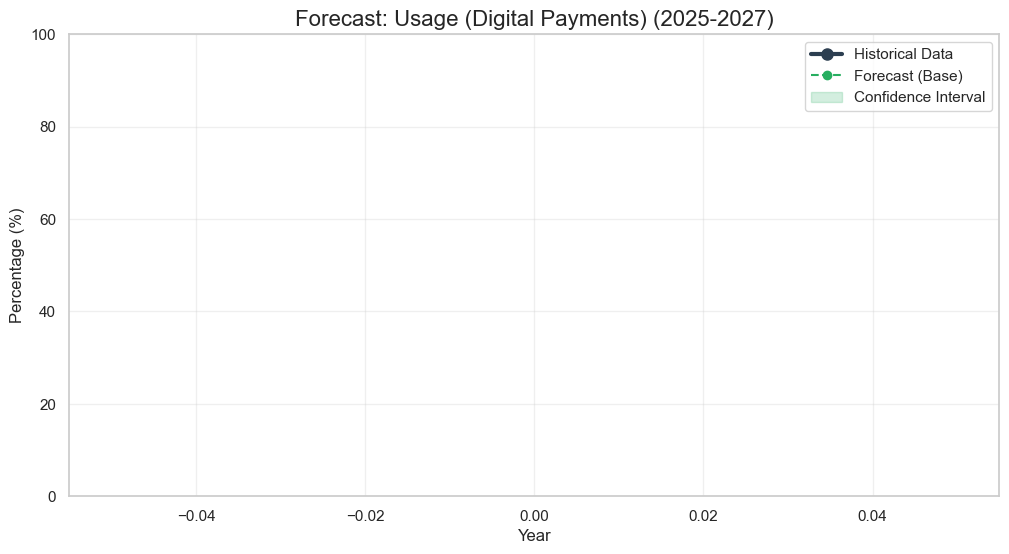

In [11]:

# ==========================================
# [Code Cell 6: Visualizing the Fan Chart]
# ==========================================
def plot_forecast(target_code):
    # Get History
    hist_data = history_df[history_df['indicator_code'] == target_code]
    
    # Get Forecast
    pred_data = forecast_df[
    (forecast_df['indicator'] == target_code) &
    (forecast_df['scenario'] == 'Base')
    ]

    
    plt.figure(figsize=(12, 6))
    
    # 1. Plot History (Actuals)
    plt.plot(hist_data['observation_date'].dt.year, hist_data['value_numeric'], 
             marker='o', markersize=8, linewidth=3, color='#2c3e50', label='Historical Data')
    
    # 2. Plot Base Forecast
    plt.plot(pred_data['year'], pred_data['value'], 
             marker='o', linestyle='--', color='#27ae60', label='Forecast (Base)')
    
    # 3. Plot Uncertainty Fan (Optimistic to Pessimistic)
    plt.fill_between(pred_data['year'], 
                     pred_data['lower_ci'], 
                     pred_data['upper_ci'], 
                     color='#27ae60', alpha=0.2, label='Confidence Interval')
    
    # Styling
    plt.title(f"Forecast: {target_names[target_code]} (2025-2027)", fontsize=16)
    plt.ylabel("Percentage (%)")
    plt.xlabel("Year")
    plt.ylim(0, 100) # Percentage scale
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Add Text Annotations
    # Add Text Annotations (only if forecast exists)
    if not pred_data.empty:
        final_val = pred_data.iloc[-1]['value']
        plt.annotate(
            f"{final_val:.1f}%",
            (pred_data.iloc[-1]['year'], final_val),
            textcoords="offset points",
            xytext=(0, 10),
            ha='center',
            fontsize=12,
            weight='bold'
        )
    else:
        print(f"⚠️ No forecast data available for {target_code}")

    
    plt.show()

# Run Plots for both indicators
for target in targets:
    plot_forecast(target)